In [4]:
from sctoolbox.utilities import bgcolor

# Batch effect correction and comparisons
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [5]:
%bgcolor PowderBlue

# Set number of cores to use for multiprocessing
threads = 4

# Options for highly variable genes
min_limit = 1000
max_limit = 5000

# Should preliminary clustering be performed?
do_clustering = True #True or False

# Options for batch correction
batch_column = "batch"  #a column in adata.obs containing batch information
perform_batch_correction = True
batch_methods = ["bbknn", "combat", "mnn", "harmony", "scanorama"]

<hr style="border:2px solid black"> </hr>

## Set up

In [6]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

import sctoolbox.utilities as utils
import sctoolbox.annotation as an
import sctoolbox.plotting as pl
import sctoolbox.analyser as analyser

## Loading the anndata

In [7]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=2)
display(adata)

AnnData object with n_obs × n_vars = 2756 × 21137
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'predicted_sex', 'n_genes', 'log1p_n_genes'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess'

In [8]:
#data_to_evaluate = adata.uns['infoprocess']['data_to_evaluate']
#adata.uns[data_to_evaluate + '_colors'] = color_list

In [9]:
figure_path = adata.uns["infoprocess"]["Anndata_path"] + "/"

In [10]:
adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

## Normalization

In [11]:
# Save raw layer before normalization
adata.layers["raw"] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=True)
sc.pp.log1p(adata)

## Find highly variable genes

Annotating highy variable genes (HVG)
Total HVG=2554


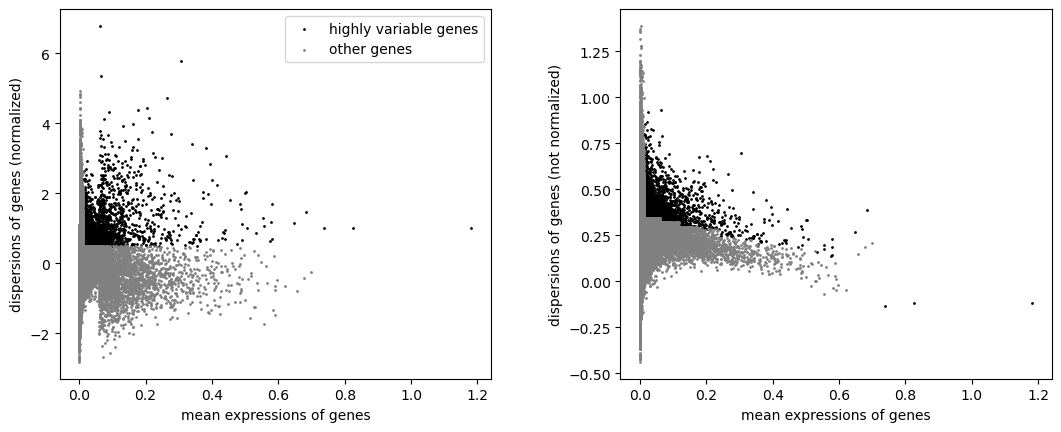

In [13]:
an.annot_HVG(adata, hvg_range=(min_limit, max_limit), save=figure_path + "highly_variable.pdf")

In [14]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

2554

## PCA and neighbors for uncorrected data

In [15]:
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


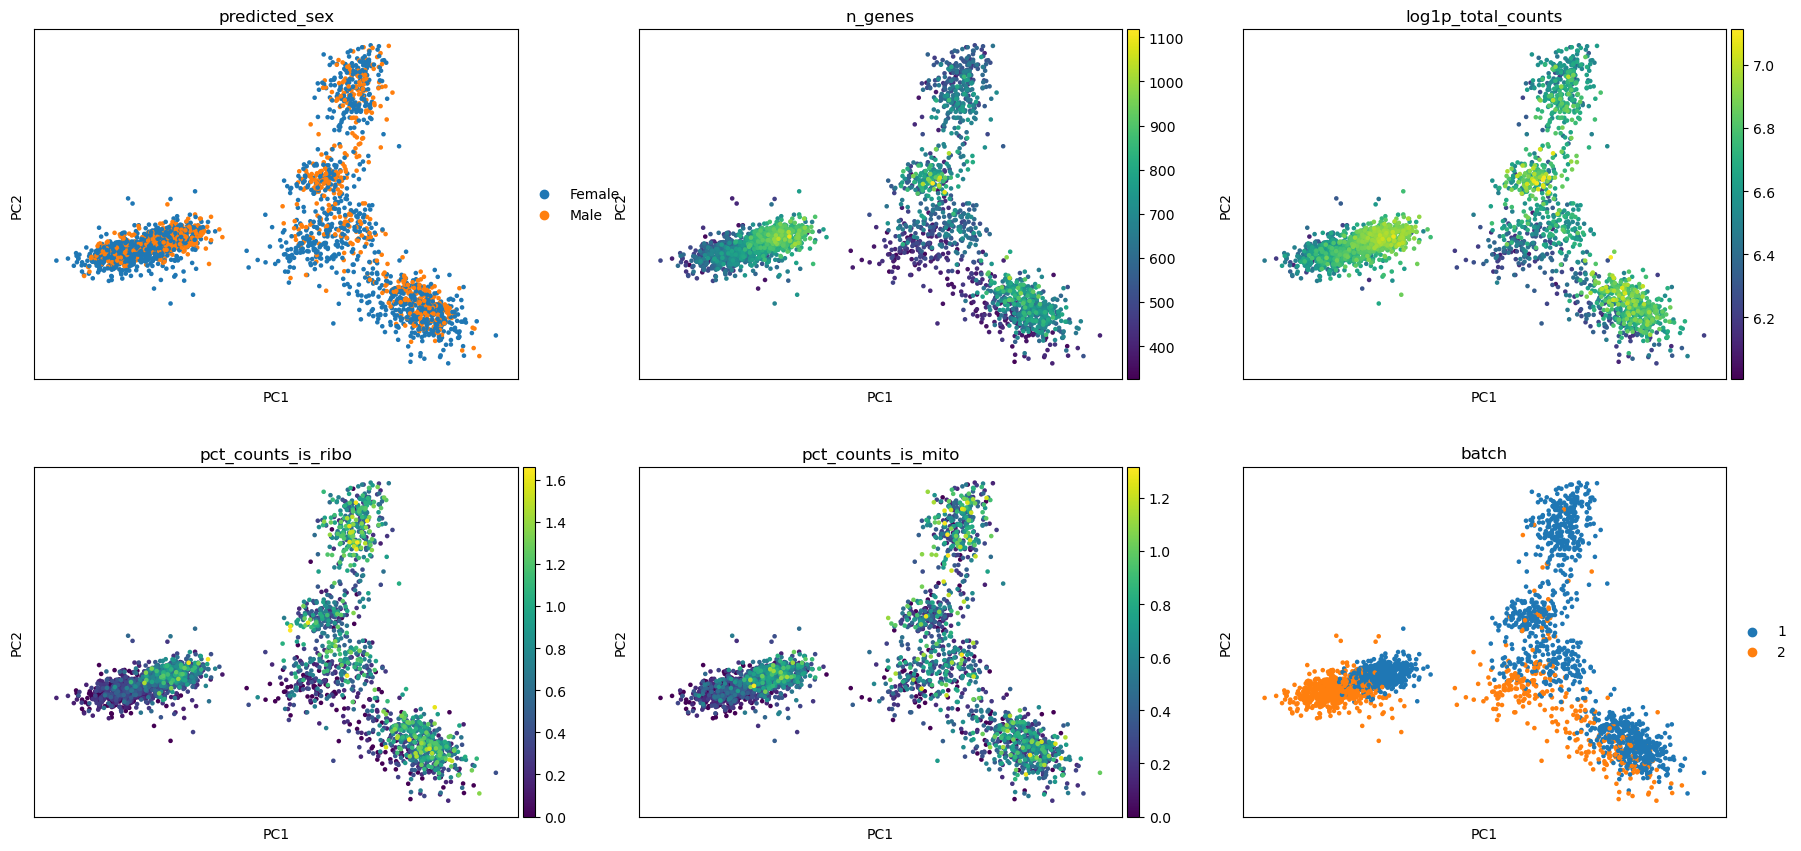

In [16]:
qc_columns = adata.uns["infoprocess"]["plot_metrics"]
sc.pl.pca(adata, color=list(qc_columns) + [batch_column], ncols=3, show=False)
utils.save_figure(figure_path + "PCA.pdf")

In [17]:
sc.pp.neighbors(adata)

## Batch correction (optional)

In [18]:
if perform_batch_correction:
    batch_corrections = analyser.wrap_corrections(adata, 
                                              batch_key=batch_column,
                                              methods=batch_methods)
else:
    batch_corrections = {"uncorrected": adata}

Running batch correction with 'bbknn'...
Running batch correction with 'combat'...


/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Running batch correction with 'mnn'...
Running batch correction with 'harmony'...
Running batch correction with 'scanorama'...
[[0.         0.88955823]
 [0.         0.        ]]
Processing datasets 1 <=> 2
Finished batch correction(s)!


### Plot overview of batch corrections

In [19]:
color_by = [batch_column]

In [20]:
#Run standard umap for all adatas
analyser.wrap_umap(batch_corrections.values(), threads=threads)

Computing UMAPs :   0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
#Perform additional clustering if it was chosen
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata)
    color_by.append("leiden")

##### LISI score:
LISI score (stored in adata.obs) indicates the effective number of different categories represented in the local neighborhood of each cell. If the cells are well-mixed, then we expect the LISI score to be closer to n for a data with n batches.

##### The higher the LISI score is, the better batch correction method worked to normalize the batch effect and mix the cells from different batches.



In [22]:
# Calculate LISI scores for batch
analyser.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

Calculating LISI scores:   0%|          | 0/12 [00:00<?, ?it/s]

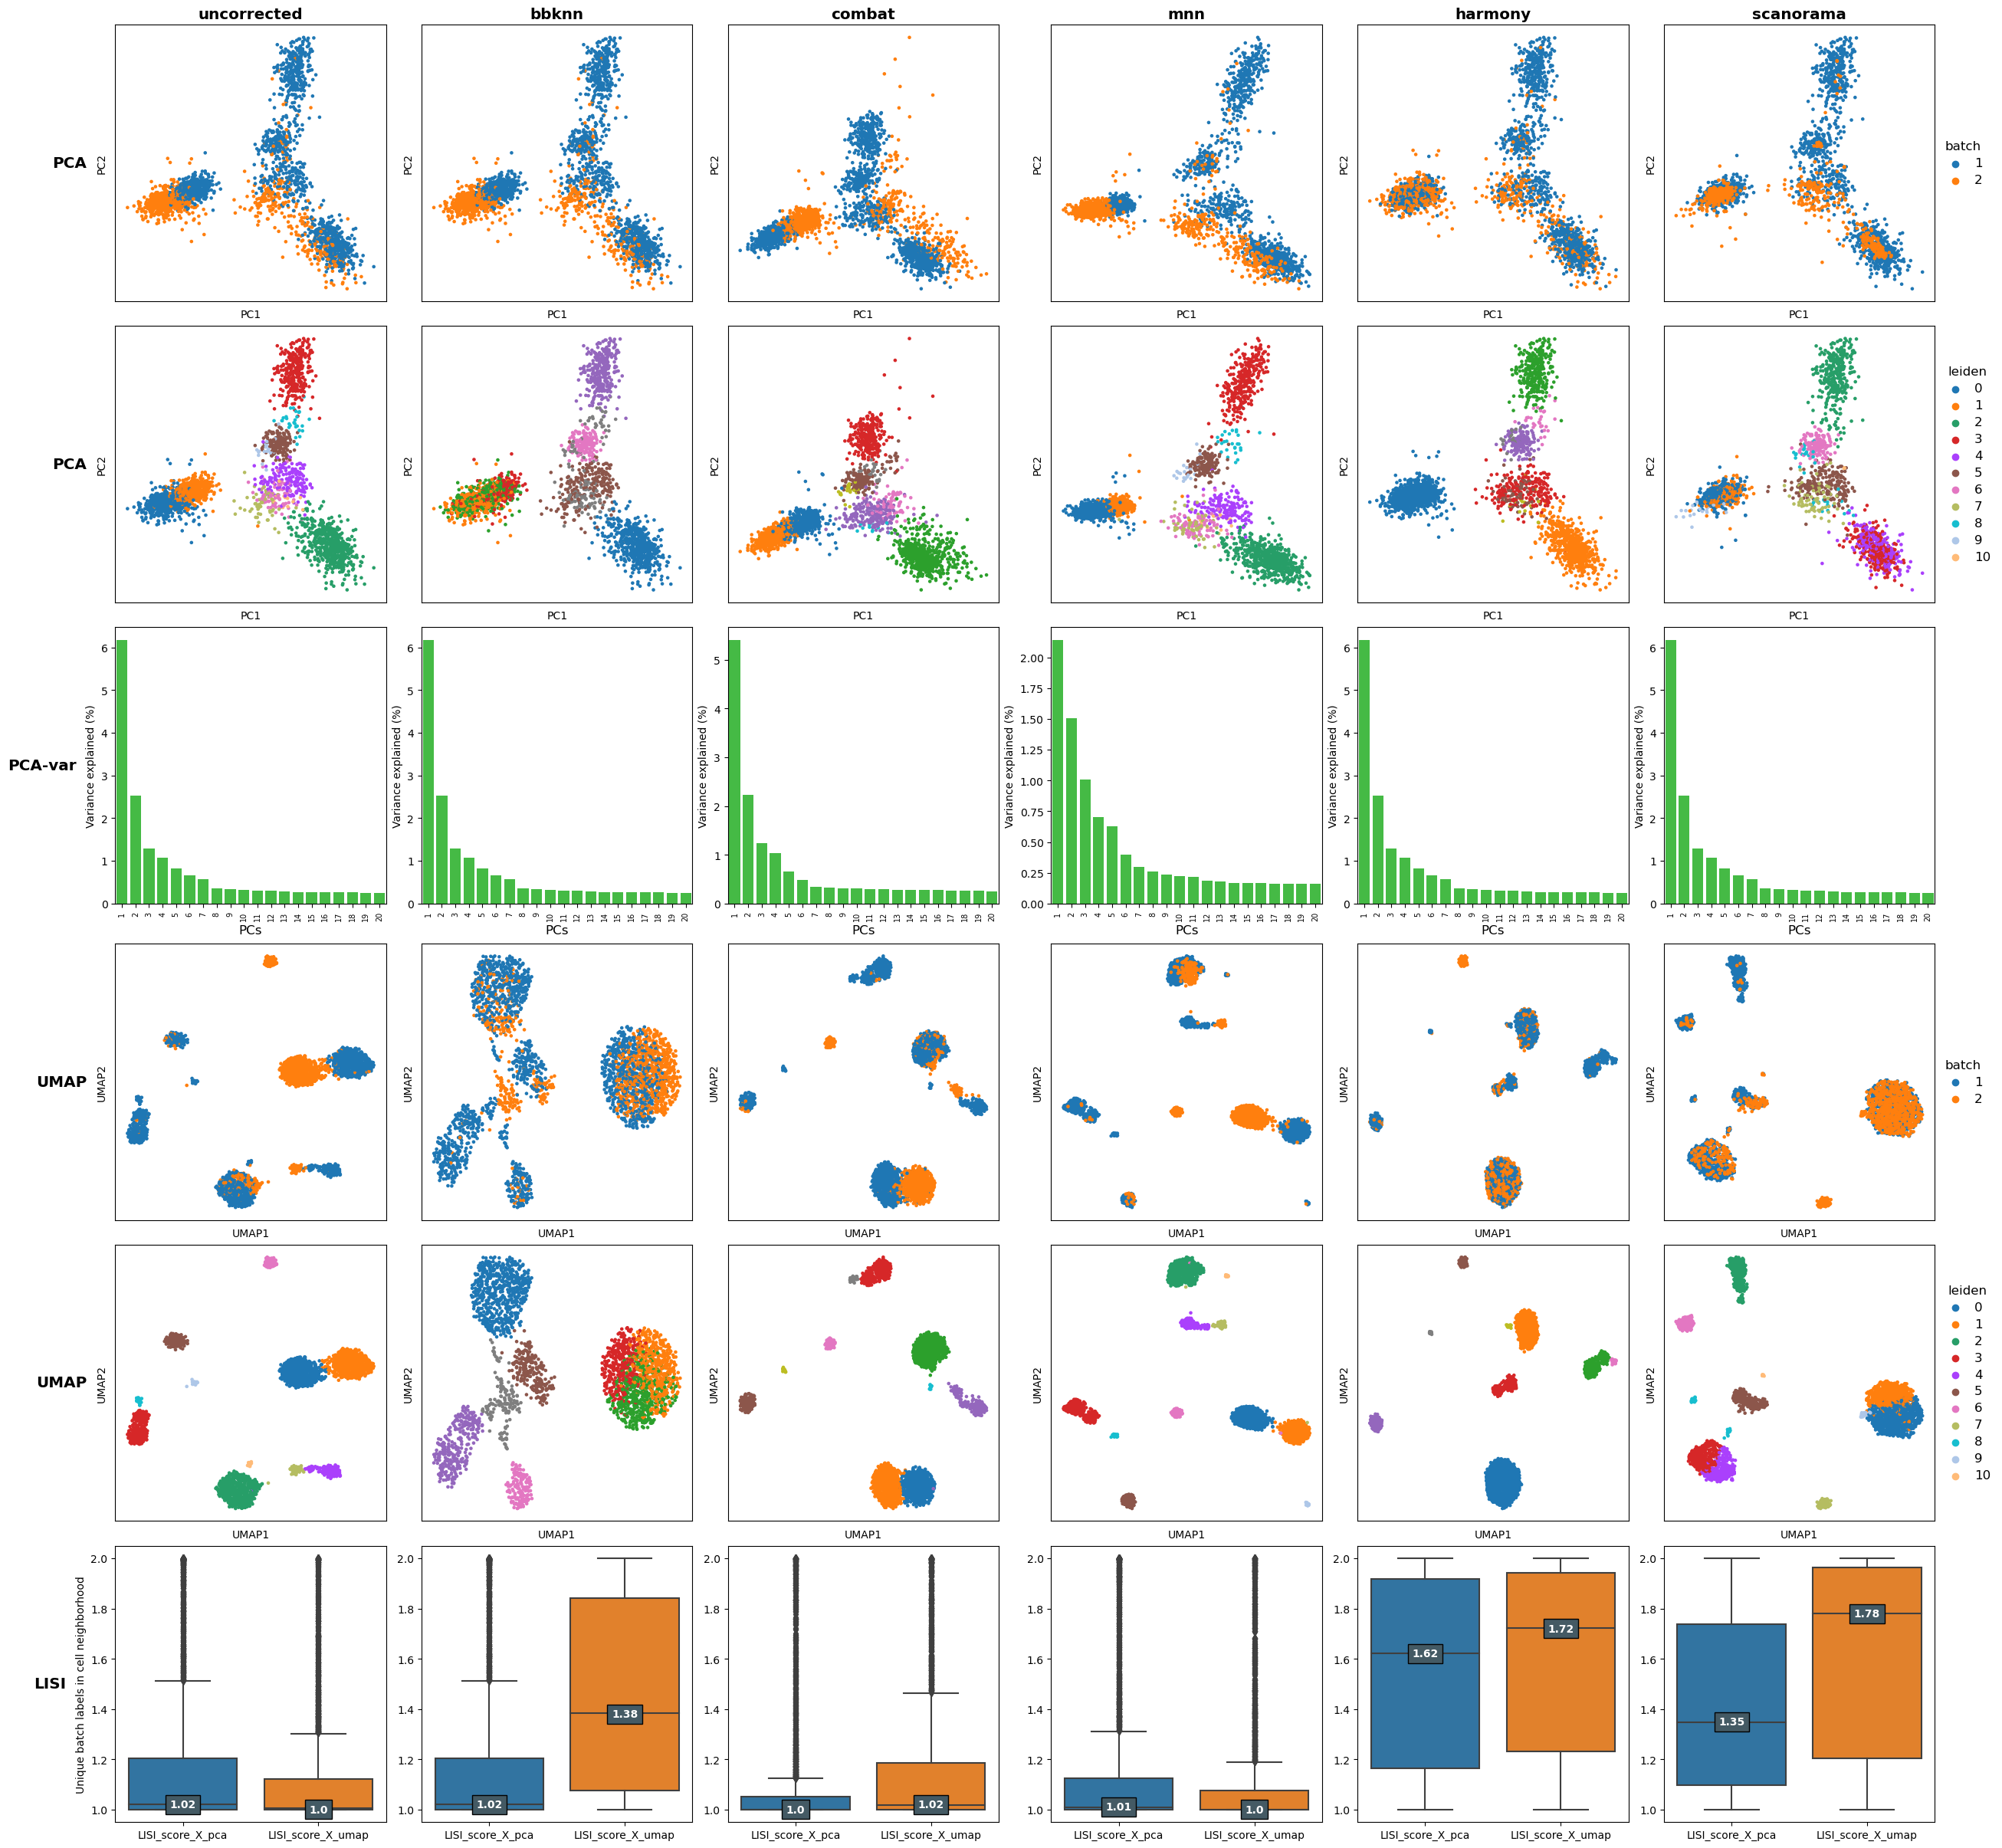

In [23]:
#Plot the overview of batch correction methods
_ = pl.anndata_overview(batch_corrections, color_by=color_by, 
                        output=figure_path + "batch_correction_overview.pdf")

### Select the final object

In [24]:
%bgcolor PowderBlue

selected = "scanorama"

In [25]:
if selected not in batch_corrections:
    raise KeyError(f"'{selected}' is not a key in batch_corrections")

In [26]:
adata = batch_corrections[selected]

## Saving adata for next notebook

In [27]:
adata

AnnData object with n_obs × n_vars = 2756 × 21137
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'predicted_sex', 'n_genes', 'log1p_n_genes', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'color_set', 'infoprocess', 'log1p', 'hvg', 'pca', 'predicted_sex_colors', 'batch_colors', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

In [28]:
utils.saving_anndata(adata, current_notebook=3)

Your new anndata object is saved here: pipeline_output/results/Test1/anndata_3_Test1.h5ad
